# White Nose Syndrome Gone "Batty" Project Notebook

<hr>
Bella Larson, Elizabeth Letch, Chloe Marshall, Serena Strode

| <a href="/WNS Gone Batty-intropage.html">Introduction</a>|<a href="/WNS Gone Batty-pre-processing.html">Preprocessing</a>|<a href="/WNS Gone Batty-model building.html">Model Building</a>|<a href="/WNS Gone Batty-discussion.html">Discussion</a>|<a href="/WNS Gone Batty-references.html">References</a>|
| ------------- | ------------- | ------------- | ------------- | ------------- |

In [3]:
# Imports

from IPython.core.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns

### Data Pre-Processing

<div>
  <figure style="float: right; margin-left: 10px; width: 400px; text-align: center;">
    <img src="regions_map.jpg" alt="Description" style="width: 100%;">
    <figcaption style="font-size: 12px; color: gray;">Figure 2 shows North America split into its major time zones.</figcaption>
  </figure>
    Here, we are going to read in our .csv file of data, which has 5 columns, and 708 rows. The first column indicates whether the data is from the United States or Canada ("country"). The next column indicates the state (USA) or province (Canada) the data is coming from ("stateprov"). The third column gives the name of the county the data is from ("county"). The fourth column gives the current status of the county as Pd Presumed, Pd Positive, WNS Suspect, or WNS Positive ("determination"). The fifth column includes a date for when that determination data was released ("release_date"). The last column gives the data collection season (a range of two years) for when the most recent status was determined ("status_season").

We know that WNS started in the northeastern region of North America and has since spread westward. We would like to be able to visualize these geographic regions in order to make predictions about WNS in western North America, using eastern North America as our example. To do this, we created five regions, based on the common time zones in North America (Pacific, Mountain, Central, Eastern, Atlantic). We disregarded that certain Canadian provinces have their own time zones, and if a state exists in multiple time zones, we chose the one that accounted for the largest portion of the state. We then created a dictionary to map each state or province (from "stateprov") into its corresponding region. We added a "Region" column to our data frame.
</div>

In [5]:
# Read in the data provided by White Nose Response Team
df = pd.read_csv("wns_county_status.csv")

# Create a dictionary to sort the state data into their appropriate time zones
region_mapping = {
         'Wyoming' : 'Mountain', 'Nebraska' : "Central", 'Mississippi': "Central", 
         'Missouri': "Central", 'South Dakota': "Central",
         'Washington': "Pacific", 'Kansas': "Central", 'Texas': "Central", 
        'North Dakota': "Central", 'Alberta': "Mountain",
       'Saskatchewan': "Mountain", 'British Columbia': "Pacific", 'Quebec': "Eastern",
       'Newfoundland and Labrador': "Atlantic", 'Manitoba': "Central", 'New Brunswick': "Atlantic",
       'Ontario': "Eastern", 'Newfoundland': "Atlantic", 'Nova Scotia': "Atlantic", 'Prince Edward': "Atlantic",
       'Louisiana': "Central", 'California': "Pacific", 'Michigan': "Eastern", 'South Carolina': "Eastern",
       'Wisconsin': "Central", 'Alabama': "Central", 'Minnesota': "Central", 'Oklahoma': "Central", 'Montana': "Mountain",
       'Georgia': "Eastern", 'Utah': "Mountain", 'Colorado': "Mountain", 'New Mexico': "Mountain", 'Arkansas': "Central",
       'Massachusetts': "Eastern", 'Idaho': "Mountain", 'Indiana': "Eastern", 'Iowa': "Central", 'North Carolina': "Eastern",
       'Pennsylvania': "Eastern", 'Illinois': "Central", 'New York': "Eastern", 'Tennessee': "Central", 'Virginia': "Eastern",
       'Kentucky': "Eastern", 'West Virginia': "Eastern", 'Ohio': "Eastern", 'Maryland': "Eastern", 'Delaware': "Eastern",
       'New Jersey': "Eastern", 'Connecticut': "Eastern", 'Rhode Island': "Eastern", 'Vermont': "Eastern",
       'New Hampshire': "Eastern", 'Maine': "Eastern"   
}

# Add a new column for the region
df['Region'] = df['stateprov'].map(region_mapping)

df.head()

,country,stateprov,county,determination,release_date,status_season,Region
0,USA,Wyoming,Laramie,WNS Positive,08/02/2024,2022-23,Mountain
1,USA,Wyoming,Albany,WNS Positive,08/02/2024,2022-23,Mountain
2,USA,Wyoming,Washakie,Pd Positive,08/02/2024,2023-24,Mountain
3,USA,Nebraska,Lancaster,Pd Positive,6/7/17,2016-17,Central
4,USA,Nebraska,Dixon,Pd Positive,6/7/17,2016-17,Central


### Plotting WNS Spread

<div>
  <figure style="float: right; margin-left: 10px; width: 400px; text-align: center;">
    <img src="WNS_spread_map_2024-11-18.png.png" alt="Description" style="width: 100%;">
    <figcaption style="font-size: 12px; color: gray;">Figure 3 shows the spread of WNS in North America.</figcaption>
  </figure>
    We want to observe how our data set models the spread of the disease in comparison to an actual map of how WNS has spread in the United States, pictured to the right. This map shows the locations of WNS cases over time, with blues indicating earlier cases than reds and orange. From this legend, we can track the spread of WNS from the northeast originally to more recent cases emerging in the west. To replicate this, we grouped the number of each determination in each region. We were then able to create a grouped bar chart, plotting the regions from west to east along the horizontal axis, and the number of each determination reported along the vertical axis. The figure to the right and the figure below show us the density of WNS in the Northeast of North America, with far greater counts of WNS in the Eastern timezone than anywhere else. Our model below doesn't factor time into the graph, but the visualization helps to understand the regions most affected, and use that information to drive future predictive models.
</div>

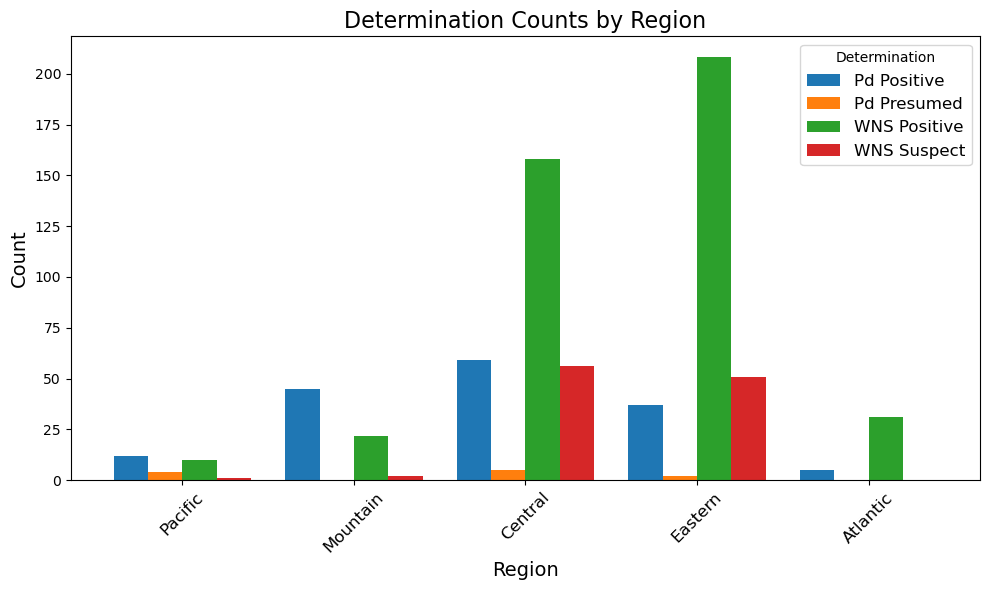

In [7]:
# Group by Region and Determination, then count occurrences
determination_counts = df.groupby(["Region", "determination"]).size().unstack(fill_value=0)

# Reorder regions to follow the actual time zones of North America, from West to East
region_order = ["Pacific", "Mountain", "Central", "Eastern", "Atlantic"]

# Count the determinations based on the order of regions
determination_counts = determination_counts.loc[region_order]

# Plot the grouped bar chart
determination_counts.plot(kind="bar", figsize=(10, 6), width=0.8)

# Customize the chart
plt.title("Determination Counts by Region", fontsize=16)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Determination", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

### Creating a New Data Frame

Next, we wanted to create a new data frame that reflected the information we were most interested in. To do this, we identified all the seasons from the "status_season" column. Then, we initialized the lists that would become our new columns in the data frame, which capture the region, season, and the numbers of each determination. We iterated through both "Regions" and "status_season" to add a counter for the number of each determination in all unique seasons within a region. 

Here, we established $\textbf{Assumption 1: If a given county's determination is "WNS Positive", then in the previous season, it was "Pd Positive"}$. 

To test if our iteration and Boolean Indexing worked as it should've, we printed a list of the regions and the counts for Pd Positive entries.

In [10]:
# Create a list of the status seasons logged in the data
seasons = np.sort(df["status_season"].unique())

# Create blank lists to create a new data frame from
regions = []
status_season_entries = []
wns_pos_entries = []
pd_pos_entries = []
wns_sus_entries = []
pd_sus_entries = []

# Sort based on region
for region in df["Region"].unique():
    for status_season_n in range(len(seasons)):
        wns_pos = 0
        pd_pos = 0
        wns_sus = 0
        pd_sus = 0
        
        # Create a counter from the last entry in the appropriate column
        if status_season_n > 0:
            wns_pos += wns_pos_entries[-1]
            pd_pos += pd_pos_entries[-1]
            wns_sus += wns_sus_entries[-1]
            pd_sus += pd_sus_entries[-1]
        
        # Sort by cases and the appropriate status season
        for idx, entry in df[(df["Region"] == region) & (df["status_season"] == seasons[status_season_n])].iterrows():
            match entry["determination"]:
                
                # Assumption 1: Counties go from Pd Presumed to Pd Positive to WNS Suspect to WNS Positive
                case "WNS Positive":
                    wns_pos += 1
                    if status_season_n != 0:
                        pd_pos_entries[-1] += 1
                case "Pd Positive":
                    pd_pos += 1
                case "WNS Suspect":
                    wns_sus += 1
                case "Pd Presumed":
                    pd_sus += 1
                
        # Add values to newly created lists for a new data frame
        regions.append(region)
        status_season_entries.append(seasons[status_season_n])
        pd_pos_entries.append(pd_pos)
        wns_pos_entries.append(wns_pos)
        wns_sus_entries.append(wns_sus)
        pd_sus_entries.append(pd_sus)

# Testing to check our Boolean Indexing and looping
print(regions, pd_pos_entries)

['Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Mountain', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Central', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Pacific', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic', 'Atlantic

Below, we actually create the new data frame, with six columns and 90 rows. This data frame shows us how many cases of each determination were identified in each season, for every region. 

In [13]:
# Create a new data frame to track regions through status seasons
df2 = pd.DataFrame()
df2["region"] = regions
df2["status_season"] = status_season_entries
df2["wns_pos"] = wns_pos_entries
df2["pd_pos"] = pd_pos_entries
df2["wns_suspected"] = wns_sus_entries
df2["pd_presumed"] = pd_sus_entries

df2

,region,status_season,wns_pos,pd_pos,wns_suspected,pd_presumed
0,Mountain,2006-07,0,0,0,0
1,Mountain,2007-08,0,0,0,0
2,Mountain,2008-09,0,0,0,0
3,Mountain,2009-10,0,0,0,0
4,Mountain,2010-11,0,0,0,0
...,...,...,...,...,...,...
85,Atlantic,2019-20,31,4,0,0
86,Atlantic,2020-21,31,5,0,0
87,Atlantic,2021-22,31,5,0,0
88,Atlantic,2022-23,31,5,0,0


| <a href="/WNS Gone Batty-intropage.html">Introduction</a>|<a href="/WNS Gone Batty-pre-processing.html">Preprocessing</a>|<a href="/WNS Gone Batty-model building.html">Model Building</a>|<a href="/WNS Gone Batty-discussion.html">Discussion</a>|<a href="/WNS Gone Batty-references.html">References</a>|
| ------------- | ------------- | ------------- | ------------- | ------------- |